['Run', 'Event', 'type1', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M']
Filtered data size after muon ID and kinematic cuts: 4858 events
Z boson mass range with ±4.0% uncertainty:
From 87.540 GeV to 94.835 GeV


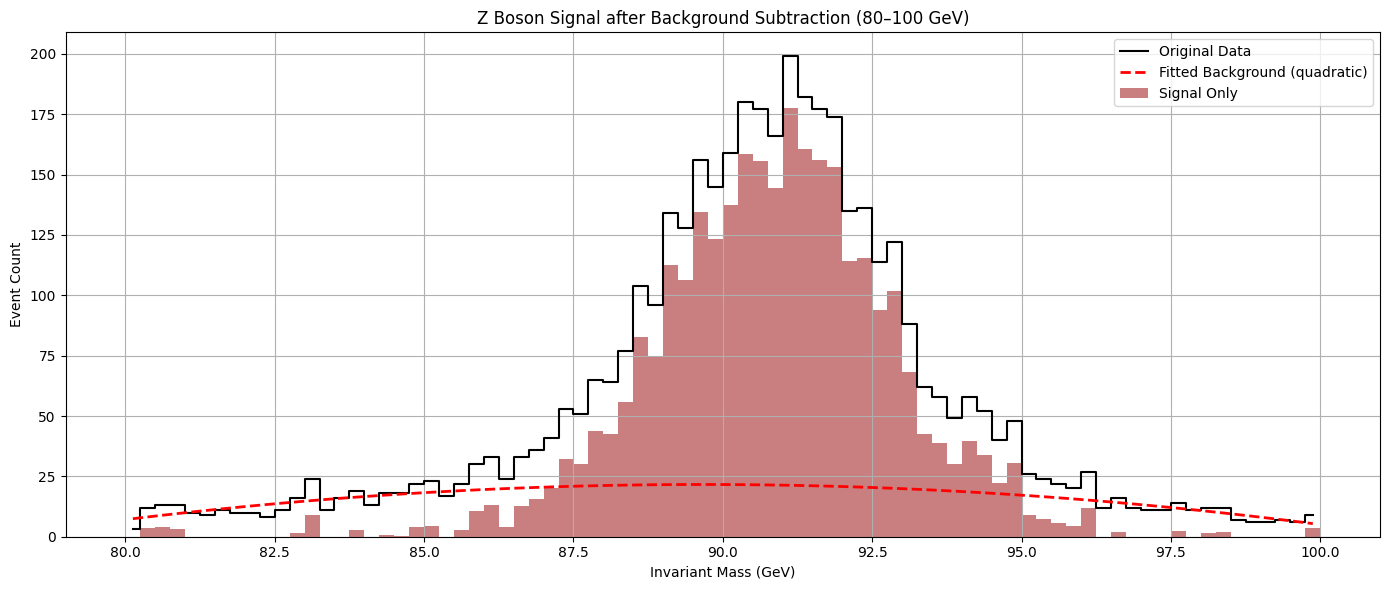

✅ Total Z boson events after background subtraction: 2976


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Load and preprocess data ---
data = pd.read_csv('/Users/xDAyN/Desktop/cs project/School Project/Dimuon_DoubleMu.csv')
print(data.columns.tolist())

# --- 2. Apply muon-level selection ---
mask_muons = (
    (data['type1'] == 'G') &
    (data['type2'] == 'G') &
    (data['pt1'] > 25) &
    (data['pt2'] > 25) &
    (np.abs(data['eta1']) < 2.4) &
    (np.abs(data['eta2']) < 2.4) &
    (data['Q1'] * data['Q2'] < 0)
)

data = data[mask_muons].reset_index(drop=True)
print(f"Filtered data size after muon ID and kinematic cuts: {len(data)} events")

# --- 3. Mass range filter ---
data = data[(data['M'] >= 0) & (data['M'] <= 120)].reset_index(drop=True)

# --- 4. Z boson mass window ---
mZ_nominal = 91.1876  # GeV
uncertainty_physics = 0.03
uncertainty_detector = 0.01
total_uncertainty = uncertainty_physics + uncertainty_detector  # 4%

mass_lower = mZ_nominal * (1 - total_uncertainty)
mass_upper = mZ_nominal * (1 + total_uncertainty)

print(f"Z boson mass range with ±{total_uncertainty*100:.1f}% uncertainty:")
print(f"From {mass_lower:.3f} GeV to {mass_upper:.3f} GeV")

# --- 5. Histogram in zoomed-in region (80–100 GeV) ---
plot_min = 80
plot_max = 100
bins = 80

masses_zoom = data[(data['M'] >= plot_min) & (data['M'] <= plot_max)]['M']
bin_edges = np.linspace(plot_min, plot_max, bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
counts, _ = np.histogram(masses_zoom, bins=bin_edges)

# --- 6. Background fit using sidebands ---
sideband_mask = ((bin_centers >= 80) & (bin_centers <= 85)) | ((bin_centers >= 97) & (bin_centers <= 100))
x_sb = bin_centers[sideband_mask]
y_sb = counts[sideband_mask]

def poly_bg(x, a, b, c):
    return a * x**2 + b * x + c

popt, _ = curve_fit(poly_bg, x_sb, y_sb)
background_fit = poly_bg(bin_centers, *popt)

# --- 7. Subtract background and clip negative values ---
signal_only = counts - background_fit
signal_only = np.clip(signal_only, 0, None)

# --- 8. Plot result ---
plt.figure(figsize=(14, 6))
plt.step(bin_centers, counts, where='mid', color='black', label='Original Data')
plt.plot(bin_centers, background_fit, 'r--', linewidth=2, label='Fitted Background (quadratic)')
plt.bar(bin_centers, signal_only, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='brown', label='Signal Only')
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Event Count')
plt.title('Z Boson Signal after Background Subtraction (80–100 GeV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Save to CSV ---
hist_df = pd.DataFrame({
    'bin_center': bin_centers,
    'bin_count': counts,
    'background_estimate': background_fit,
    'signal_only': signal_only
})
hist_df.to_csv('/Users/xDAyN/Desktop/cs project/School Project/Numerical Analysis/zboson_background_subtracted_histogram.csv', index=False)

# --- 10. Count Z boson signal events after background subtraction ---
total_signal_events = np.sum(signal_only)
print(f"✅ Total Z boson events after background subtraction: {int(total_signal_events)}")
